In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from string import punctuation

In [2]:
sw_indo = stopwords.words("indonesian") + list(punctuation)

# Import Data

In [3]:
df = pd.read_csv("data/gojek_review_sentiment.csv")
df.head()

,review,rate
0,Apa aplikasi yang bagus untuk dengan mudah per...,positive
1,Aplikasi ini banyak membantu saya. Sekarang sa...,positive
2,Mengerikan. Antarmukanya sangat membingungkan....,negative
3,Aplikasi yang cukup mengesankan. Butuh waktu l...,positive
4,Aplikasi ini sebenarnya bagus dan sangat memba...,positive


In [4]:
df.rate.value_counts()

negative    1061
positive     721
Name: rate, dtype: int64

In [5]:
df.rate.value_counts(normalize=True)

negative    0.595398
positive    0.404602
Name: rate, dtype: float64

# Encoding

- untuk model bisa didownload disini

In [6]:
from gensim.models import FastText

In [7]:
w2v = FastText.load("model/fasttext/gojek_review.fasttext")


In [8]:
def sent_vector(sentence, w2v_model, stopwords):
    vecs = [w2v_model[word.lower()]for word in word_tokenize(sentence) if word not in stopwords]
    sent_vec = np.mean(vecs, axis=0)
    return sent_vec

def norm_sent_vector(sentence, w2v_model, stopwords):
    vecs = [w2v_model[word.lower()]for word in word_tokenize(sentence) if word not in stopwords]
    norm_vecs = [vec / np.linalg.norm(vec) for vec in vecs if np.linalg.norm(vec) > 0]
    sent_vec = np.mean(vecs, axis=0)
    return sent_vec



In [9]:
vecs = [norm_sent_vector(sentence, w2v, sw_indo)for sentence in df.review]
vecs = np.array(vecs)
vecs

C:\Users\IKIN\Miniconda3\envs\jcop_wv\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


array([[-0.11573789, -0.02497726, -0.2157648 , ..., -0.01205566,
         0.30220798, -0.46631387],
       [ 0.3292053 , -0.19083382, -0.3220397 , ...,  0.15068418,
         0.30892754, -0.26422483],
       [ 0.32759935, -0.26869676, -0.01399194, ...,  0.13684213,
         0.5048621 , -0.4104103 ],
       ...,
       [-0.31635115, -0.00686186, -0.28163067, ..., -0.05505691,
         0.11495497, -0.4080724 ],
       [-0.02645294,  0.18514413, -0.7215645 , ..., -0.06857064,
         0.57473207, -0.44977635],
       [-0.03315772, -0.18328333, -0.24807443, ..., -0.03581586,
         0.25923756, -0.57495034]], dtype=float32)

# Dataset splitting

In [10]:
X = vecs
y = df.rate

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1425, 128), (357, 128), (1425,), (357,))

# Training

In [11]:
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp

from sklearn.feature_extraction.text import CountVectorizer

In [12]:
pipeline = Pipeline([
    ("algo", SVC(max_iter=500))
])

model = RandomizedSearchCV(pipeline, rsp.svm_params, cv=4, n_iter=50, verbose=1, n_jobs=-1)
model.fit(X_train, y_train)

print(model.best_params_)
print("score for data train : ", model.score(X_train, y_train))
print("score for data test : ", model.score(X_test, y_test))

Fitting 4 folds for each of 50 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  2.4min finished
C:\Users\IKIN\Miniconda3\envs\jcop_wv\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


{'algo__C': 57.9950830121298, 'algo__gamma': 0.003335332723144112}
score for data train :  0.9010526315789473
score for data test :  0.8851540616246498


In [13]:
from jcopml.plot import plot_confusion_matrix

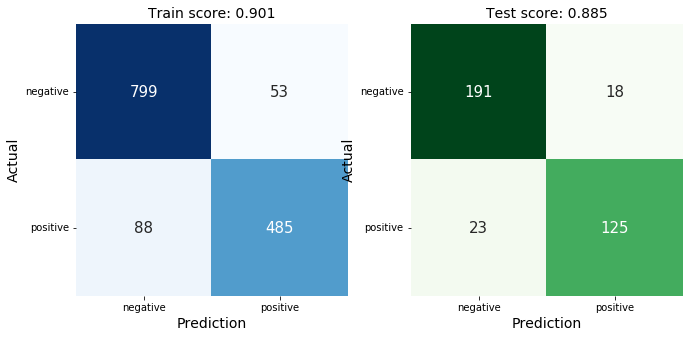

In [14]:
plot_confusion_matrix(X_train, y_train, X_test, y_test, model)